<a href="https://colab.research.google.com/github/Khajinova/python-5-sem/blob/main/dense_conv_nn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключите нужные библиотеки и убедитесь в правильности выбранного устройства. Для начала советую писать на cpu, а на видеокарту переключаться, когда большая часть кода будет готова, чтобы не расходовать лишний ресурс. Чтобы подключить видеокарту, необходимо в настройках сменить среду выполнения на T4GPU. Если видеокарта подключилась успешно, блок кода ниже напечатает cuda.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Для начала разберемся с данными. Мы будем использовать датасет mnist, картинки рукописных надписей десятичных цифр.

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch.shape, y_batch.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


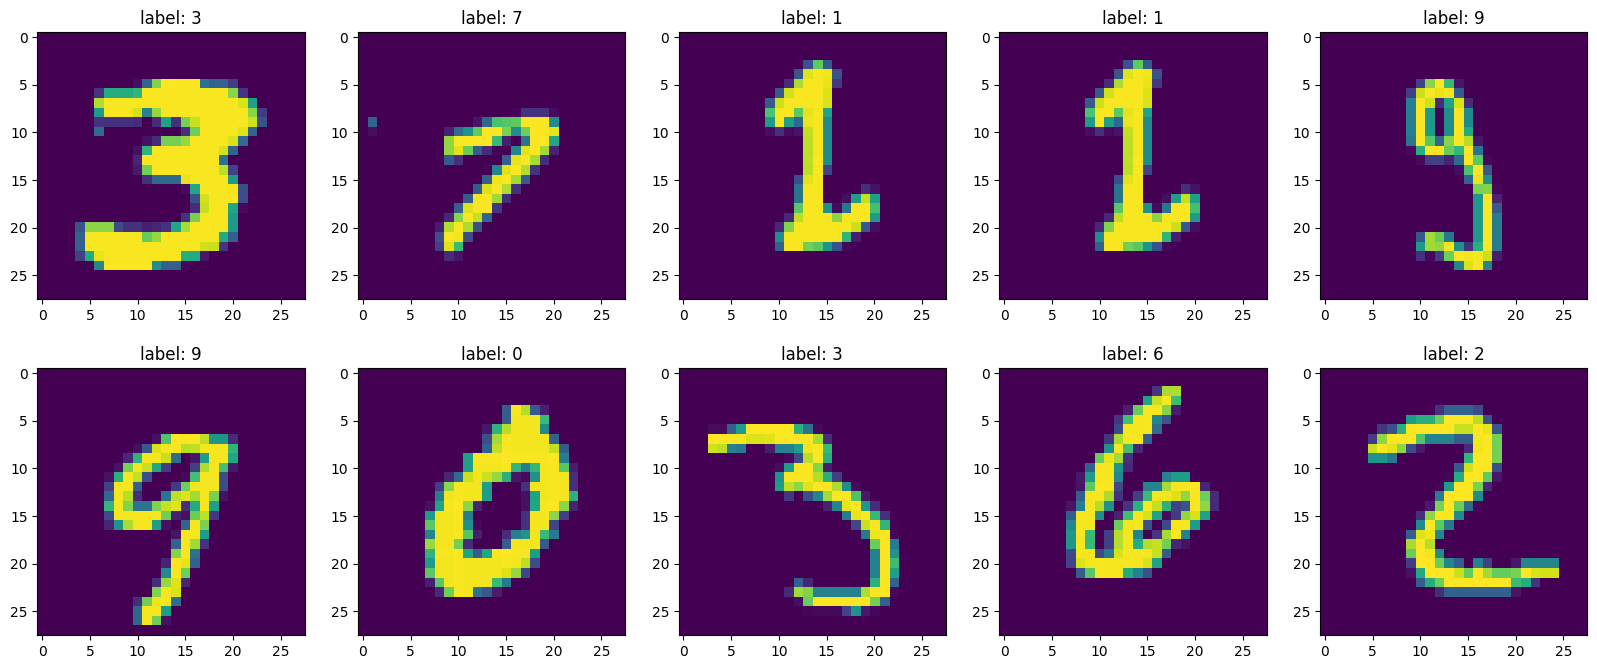

In [ ]:
indexes = np.random.randint(X_batch.shape[0], size = 10)
plt.figure(figsize=(20, 8))
for i, index in enumerate(indexes):
  x = plt.subplot(2, 5, i+1)
  x.title.set_text(f"label: {y_batch[index]}")
  plt.imshow(X_batch[index][0])
plt.show()

Как видно с печатей, mnist состоит из одноканальных изображений 28x28 пикселей. Ваша задача - научить свои модели определять цифру на картинке.

Для начала реализуем класс линейной регрессии, используя возможности PyTorch. Дополните код ниже до корректной работы.

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_weights = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_weights
        return x

На практике, вместо своего класса можно использовать nn.Linear, обладающий такой же сигнатурой.

In [ ]:
linear_model = nn.Sequential(
    nn.Flatten(),
    LinearRegression(28 ** 2, 10)
).to(device)

optimizer = torch.optim.Adam(linear_model.parameters())

criterion = nn.CrossEntropyLoss()

Sequential последовательно применит свои аргументы к пропускаемым через него аргументам, его удобно использовать для создания простых моделей или блоков внутри сложных. В качестве функции потерь берем стандартную для классификаторов кросс-энтропию. В качестве метрики будем использовать обычную accuracy, ее легко реализовать руками.

In [ ]:
def learning_loop(tr_loader, val_loader, model, loss_fn, optim, epochs=20):
    tr_history = []
    val_history = []

    for epoch in tqdm(range(epochs)):
        tr_loss, tr_acc = train_epoch(tr_loader, model, loss_fn, optim)
        val_loss, val_acc = eval_epoch(val_loader, model, loss_fn)

        tr_history.append((tr_loss, tr_acc))
        val_history.append((val_loss, val_acc))

        print(f"epoch: {epoch + 1}; losses: {tr_loss}, {val_loss}; accuracy: {tr_acc}, {val_acc}")

    return tr_history, val_history



In [ ]:
def train_epoch(data_loader, model, loss_fn, optim):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optim.step()

        loss_val = loss.item()
        preds = logits.argmax(-1)
        correct = preds == y_batch

        total_loss += loss_val * y_batch.size(0)
        total_correct += correct.sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [ ]:
def eval_epoch(data_loader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.set_grad_enabled(False):
            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

        total_loss += loss.item() * y_batch.size(0)
        preds = logits.argmax(-1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy



In [ ]:
epochs = 20
train_history, val_history = learning_loop(
    train_dataloader, valid_dataloader, linear_model, criterion, optimizer, epochs=epochs
)

train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)


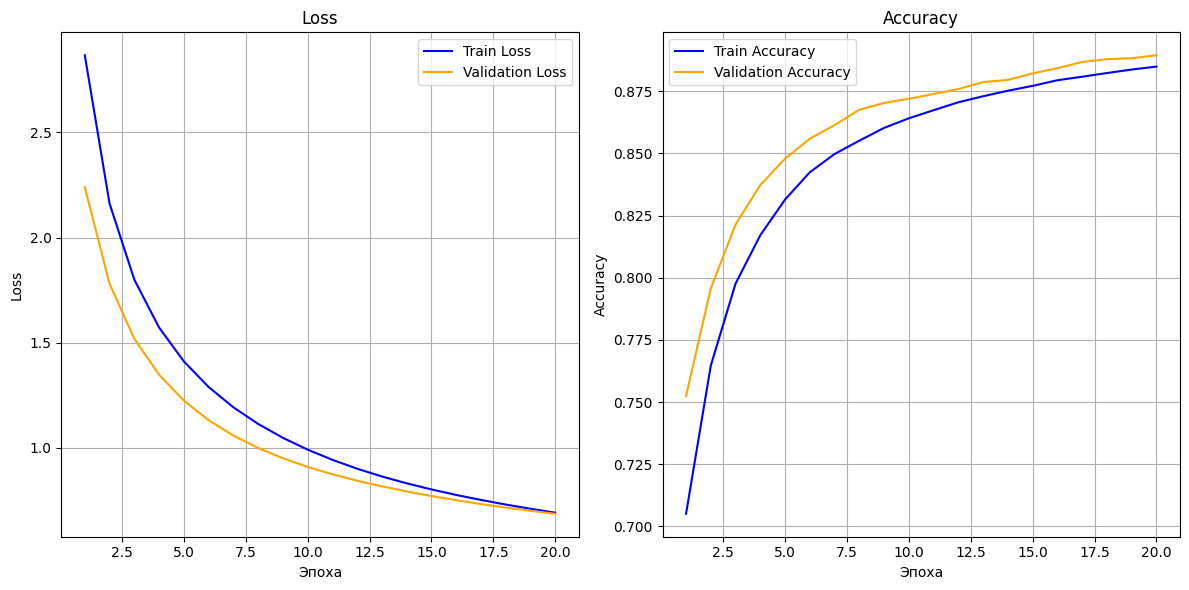

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="blue")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class DenseNetwork(nn.Module):
    def __init__(self, in_features=28**2, out_features=10, activ=None):
        super().__init__()
        if activ is None:
            activ = nn.ReLU()
        self.flat = nn.Flatten()
        self.activ = activ
        self.linear_1 = nn.Linear(in_features, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.flat(x)
        x = self.activ(self.linear_1(x))
        x = self.activ(self.linear_2(x))
        x = self.linear_3(x)
        return x

Можно ли было в данном случае не писать класс, а просто применить Sequential? Да, но оформив модель через класс мы имеем возможность потом модифицировать поведение уже обученной модели, обратившись к её полям.

In [ ]:
model = DenseNetwork(in_features=28**2, out_features=10, activ=nn.ReLU()).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20
train_history, val_history = learning_loop(
    train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=epochs
)

train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)

  5%|▌         | 1/20 [00:18<05:48, 18.32s/it]

epoch: 1; losses: 0.4661662886460622, 0.25733537120819094; accuracy: 0.8639, 0.9213


 10%|█         | 2/20 [00:38<05:50, 19.48s/it]

epoch: 2; losses: 0.23952459656794867, 0.17903300300240516; accuracy: 0.9280666666666667, 0.9441


 15%|█▌        | 3/20 [00:55<05:13, 18.47s/it]

epoch: 3; losses: 0.1680607830842336, 0.15307264686971903; accuracy: 0.94915, 0.9532


 20%|██        | 4/20 [01:14<04:56, 18.55s/it]

epoch: 4; losses: 0.1311640998462836, 0.1303493049994111; accuracy: 0.96035, 0.9591


 25%|██▌       | 5/20 [01:34<04:44, 18.96s/it]

epoch: 5; losses: 0.10866011420488357, 0.11683163488358259; accuracy: 0.9672833333333334, 0.9641


 30%|███       | 6/20 [01:52<04:23, 18.83s/it]

epoch: 6; losses: 0.0930007796506087, 0.11192083937861025; accuracy: 0.9721333333333333, 0.9653


 35%|███▌      | 7/20 [02:11<04:04, 18.85s/it]

epoch: 7; losses: 0.08234490462442239, 0.1106216522026807; accuracy: 0.9746, 0.9649


 40%|████      | 8/20 [02:28<03:38, 18.21s/it]

epoch: 8; losses: 0.07217586691478889, 0.11568481588438154; accuracy: 0.9775833333333334, 0.9639


 45%|████▌     | 9/20 [02:45<03:15, 17.75s/it]

epoch: 9; losses: 0.06471260716021061, 0.10478434838522226; accuracy: 0.98, 0.9664


 50%|█████     | 10/20 [03:02<02:56, 17.63s/it]

epoch: 10; losses: 0.05915491790622473, 0.10693060018299147; accuracy: 0.9809666666666667, 0.9669


 55%|█████▌    | 11/20 [03:19<02:37, 17.53s/it]

epoch: 11; losses: 0.05314920552819967, 0.10804922151481733; accuracy: 0.9829333333333333, 0.968


 60%|██████    | 12/20 [03:36<02:19, 17.38s/it]

epoch: 12; losses: 0.04841758722414573, 0.10217533362379763; accuracy: 0.9842333333333333, 0.9718


 65%|██████▌   | 13/20 [03:54<02:01, 17.31s/it]

epoch: 13; losses: 0.04523690870255232, 0.11684243843785953; accuracy: 0.9854833333333334, 0.9664


 70%|███████   | 14/20 [04:11<01:44, 17.46s/it]

epoch: 14; losses: 0.043245253792405125, 0.12161819568739739; accuracy: 0.9856166666666667, 0.9665


 75%|███████▌  | 15/20 [04:28<01:26, 17.30s/it]

epoch: 15; losses: 0.03817165927216411, 0.11785340188303962; accuracy: 0.98755, 0.9673


 80%|████████  | 16/20 [04:45<01:08, 17.12s/it]

epoch: 16; losses: 0.035585966455439724, 0.10737832700417493; accuracy: 0.9880333333333333, 0.9697


 85%|████████▌ | 17/20 [05:03<00:52, 17.35s/it]

epoch: 17; losses: 0.03248107370721797, 0.11946933098910377; accuracy: 0.9892, 0.9667


 90%|█████████ | 18/20 [05:20<00:34, 17.20s/it]

epoch: 18; losses: 0.02865808889673402, 0.12124198595986235; accuracy: 0.9902, 0.9682


 95%|█████████▌| 19/20 [05:37<00:17, 17.07s/it]

epoch: 19; losses: 0.02907429429634164, 0.12205676814976614; accuracy: 0.9898166666666667, 0.9684


100%|██████████| 20/20 [05:55<00:00, 17.77s/it]

epoch: 20; losses: 0.027153916431653, 0.10855729430558277; accuracy: 0.9906, 0.9737


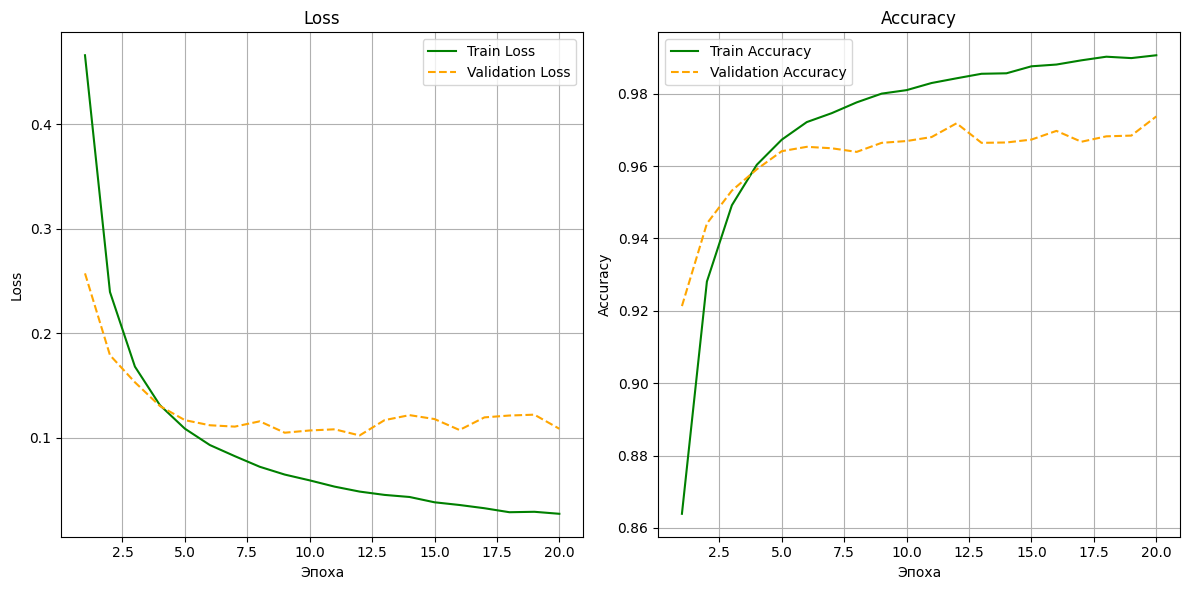

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="green")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="orange", linestyle='--')
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="green")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="orange", linestyle='--')
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Создайте новые модели с другими функциями активации. Попробуйте: гиперболический тангенс, сигмоиду, ELU, LeakyReLU. Все их можно найти в torch.nn.functional. Обучите их, постройте и сравните между собой графики обучения.

In [ ]:
def train_and_evaluate(activation_function, train_loader, val_loader, epochs=20):
    model = DenseNetwork(activ_func=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    train_history, val_history = learning_loop(
        train_loader, val_loader, model, criterion, optimizer, epochs=epochs
    )

    return train_history, val_history


In [ ]:
class DenseNetwork(nn.Module):
    def __init__(self, in_features=28**2, out_features=10, activ=F.relu):
        super().__init__()
        self.flat = nn.Flatten()
        self.linear_1 = nn.Linear(in_features, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, out_features)
        self.activ = activ

    def forward(self, x):
        x = self.flat(x)
        x = self.activ(self.linear_1(x))
        x = self.activ(self.linear_2(x))
        x = self.linear_3(x)
        return x

def train_and_evaluate(activation_function, train_loader, val_loader, epochs=20):
    model = DenseNetwork(activ=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    train_history, val_history = learning_loop(
        train_loader, val_loader, model, criterion, optimizer, epochs=epochs
    )

    return train_history, val_history

activations = {
    "ReLU": F.relu,
    "Tanh": F.tanh,
    "Sigmoid": F.sigmoid,
    "ELU": F.elu,
    "LeakyReLU": F.leaky_relu
}

history = {}

for name, activ in activations.items():
    print(f"Training model with {name} activation function")
    train_history, val_history = train_and_evaluate(activ, train_dataloader, valid_dataloader)
    history[name] = (train_history, val_history)


Training model with ReLU activation function


  5%|▌         | 1/20 [00:14<04:35, 14.52s/it]

epoch: 1; losses: 0.448078861784935, 0.2580310460448265; accuracy: 0.8658666666666667, 0.9196


 10%|█         | 2/20 [00:29<04:23, 14.61s/it]

epoch: 2; losses: 0.22856253667275112, 0.17975414390563965; accuracy: 0.9315333333333333, 0.9438


 15%|█▌        | 3/20 [00:44<04:17, 15.12s/it]

epoch: 3; losses: 0.16015197272102039, 0.1430116757363081; accuracy: 0.9510833333333333, 0.9562


 20%|██        | 4/20 [01:00<04:03, 15.22s/it]

epoch: 4; losses: 0.12373127956589063, 0.13796593127697707; accuracy: 0.9624833333333334, 0.9575


 25%|██▌       | 5/20 [01:15<03:45, 15.05s/it]

epoch: 5; losses: 0.1018020844846964, 0.12604602982699872; accuracy: 0.9687833333333333, 0.9614


 30%|███       | 6/20 [01:29<03:29, 14.96s/it]

epoch: 6; losses: 0.08535211906333764, 0.1188171853363514; accuracy: 0.9744, 0.964


 35%|███▌      | 7/20 [01:44<03:13, 14.90s/it]

epoch: 7; losses: 0.07308676815778017, 0.11641023206561804; accuracy: 0.9771, 0.9651


 40%|████      | 8/20 [01:59<02:58, 14.86s/it]

epoch: 8; losses: 0.06399827860742807, 0.10844636958390474; accuracy: 0.9799833333333333, 0.9671


 45%|████▌     | 9/20 [02:14<02:43, 14.90s/it]

epoch: 9; losses: 0.05564654879619678, 0.11926880068476312; accuracy: 0.982, 0.9654


 50%|█████     | 10/20 [02:29<02:30, 15.01s/it]

epoch: 10; losses: 0.0502419904867808, 0.11774246953437105; accuracy: 0.9839, 0.9657


 55%|█████▌    | 11/20 [02:44<02:14, 14.89s/it]

epoch: 11; losses: 0.04673099163000782, 0.1193964865467744; accuracy: 0.9851333333333333, 0.9687


 60%|██████    | 12/20 [02:58<01:58, 14.80s/it]

epoch: 12; losses: 0.04292578922485312, 0.1256807731941808; accuracy: 0.9855166666666667, 0.9682


 65%|██████▌   | 13/20 [03:13<01:43, 14.76s/it]

epoch: 13; losses: 0.03742702001556754, 0.14393389086183161; accuracy: 0.98705, 0.9642


 70%|███████   | 14/20 [03:28<01:28, 14.73s/it]

epoch: 14; losses: 0.036247194971020025, 0.1082083206740208; accuracy: 0.98755, 0.9716


 75%|███████▌  | 15/20 [03:43<01:13, 14.77s/it]

epoch: 15; losses: 0.03346518262637158, 0.129666196200205; accuracy: 0.98865, 0.9682


 80%|████████  | 16/20 [03:58<00:59, 14.88s/it]

epoch: 16; losses: 0.02980059650732825, 0.14006861928063155; accuracy: 0.98965, 0.9683


 85%|████████▌ | 17/20 [04:12<00:44, 14.73s/it]

epoch: 17; losses: 0.03060708606404563, 0.12737950993493286; accuracy: 0.9896, 0.9697


 90%|█████████ | 18/20 [04:26<00:29, 14.64s/it]

epoch: 18; losses: 0.027932942661022146, 0.13895866636058346; accuracy: 0.9904333333333334, 0.9698


 95%|█████████▌| 19/20 [04:41<00:14, 14.55s/it]

epoch: 19; losses: 0.02616078654738764, 0.10737344534865552; accuracy: 0.9909166666666667, 0.9742


100%|██████████| 20/20 [04:56<00:00, 14.80s/it]


epoch: 20; losses: 0.024893609448087713, 0.12055977323961997; accuracy: 0.9909666666666667, 0.9722
Training model with Tanh activation function


  5%|▌         | 1/20 [00:14<04:30, 14.24s/it]

epoch: 1; losses: 0.4007477831840515, 0.2129749597787857; accuracy: 0.8837333333333334, 0.9346


 10%|█         | 2/20 [00:29<04:23, 14.62s/it]

epoch: 2; losses: 0.18557236934105556, 0.14544771602153778; accuracy: 0.9441, 0.9557


 15%|█▌        | 3/20 [00:43<04:07, 14.56s/it]

epoch: 3; losses: 0.13544434582789738, 0.12125950032025576; accuracy: 0.9590166666666666, 0.9621


 20%|██        | 4/20 [00:57<03:50, 14.40s/it]

epoch: 4; losses: 0.10726906658907731, 0.12013051130883395; accuracy: 0.9672666666666667, 0.9609


 25%|██▌       | 5/20 [01:11<03:34, 14.31s/it]

epoch: 5; losses: 0.09051523109575113, 0.11411771835759282; accuracy: 0.9727, 0.9644


 30%|███       | 6/20 [01:26<03:20, 14.33s/it]

epoch: 6; losses: 0.07800985815574725, 0.11525753255672753; accuracy: 0.9757833333333333, 0.9645


 35%|███▌      | 7/20 [01:40<03:05, 14.24s/it]

epoch: 7; losses: 0.07299347722729047, 0.12218312547393143; accuracy: 0.97655, 0.9615


 40%|████      | 8/20 [01:54<02:51, 14.25s/it]

epoch: 8; losses: 0.06830255646208921, 0.12694719390012324; accuracy: 0.9780833333333333, 0.9618


 45%|████▌     | 9/20 [02:09<02:37, 14.35s/it]

epoch: 9; losses: 0.06334584703445434, 0.13105875608408823; accuracy: 0.9787666666666667, 0.96


 50%|█████     | 10/20 [02:24<02:25, 14.51s/it]

epoch: 10; losses: 0.05920940430214008, 0.12644216590840368; accuracy: 0.9808666666666667, 0.962


 55%|█████▌    | 11/20 [02:38<02:09, 14.43s/it]

epoch: 11; losses: 0.05173920141905546, 0.15770552793443202; accuracy: 0.9832, 0.9541


 60%|██████    | 12/20 [02:52<01:54, 14.33s/it]

epoch: 12; losses: 0.04884915108829737, 0.12696820809319614; accuracy: 0.9841833333333333, 0.9625


 65%|██████▌   | 13/20 [03:06<01:40, 14.32s/it]

epoch: 13; losses: 0.044403809529542926, 0.12495836460711435; accuracy: 0.9852166666666666, 0.9654


 70%|███████   | 14/20 [03:21<01:25, 14.31s/it]

epoch: 14; losses: 0.04611098415503899, 0.12222907202728092; accuracy: 0.98435, 0.9654


 75%|███████▌  | 15/20 [03:35<01:11, 14.31s/it]

epoch: 15; losses: 0.043019620282451314, 0.13830837158337236; accuracy: 0.9853666666666666, 0.9608


 80%|████████  | 16/20 [03:49<00:57, 14.30s/it]

epoch: 16; losses: 0.040444176515936854, 0.1377996811211109; accuracy: 0.9864166666666667, 0.9612


 85%|████████▌ | 17/20 [04:04<00:43, 14.50s/it]

epoch: 17; losses: 0.03821074374392629, 0.12527917428892105; accuracy: 0.9872166666666666, 0.965


 90%|█████████ | 18/20 [04:19<00:28, 14.48s/it]

epoch: 18; losses: 0.03780636156226198, 0.1109736505240202; accuracy: 0.9873833333333333, 0.9703


 95%|█████████▌| 19/20 [04:33<00:14, 14.41s/it]

epoch: 19; losses: 0.03448143514270584, 0.11634449799004942; accuracy: 0.9884, 0.9686


100%|██████████| 20/20 [04:47<00:00, 14.37s/it]


epoch: 20; losses: 0.031142960525552432, 0.1356476828292478; accuracy: 0.9895, 0.9648
Training model with Sigmoid activation function


  5%|▌         | 1/20 [00:14<04:38, 14.65s/it]

epoch: 1; losses: 0.7618099869410196, 0.3111985367536545; accuracy: 0.7955833333333333, 0.9071


 10%|█         | 2/20 [00:29<04:22, 14.56s/it]

epoch: 2; losses: 0.2675954643249512, 0.21785628618001937; accuracy: 0.9218166666666666, 0.936


 15%|█▌        | 3/20 [00:44<04:10, 14.71s/it]

epoch: 3; losses: 0.19634369860490164, 0.1728798650622368; accuracy: 0.9423166666666667, 0.9477


 20%|██        | 4/20 [00:59<03:58, 14.92s/it]

epoch: 4; losses: 0.15387527567942938, 0.14649442777633667; accuracy: 0.9553, 0.9561


 25%|██▌       | 5/20 [01:13<03:41, 14.79s/it]

epoch: 5; losses: 0.12547765631079674, 0.12897492486536502; accuracy: 0.9635333333333334, 0.9614


 30%|███       | 6/20 [01:28<03:24, 14.61s/it]

epoch: 6; losses: 0.10504129829208056, 0.11601591676175595; accuracy: 0.97005, 0.9647


 35%|███▌      | 7/20 [01:42<03:07, 14.44s/it]

epoch: 7; losses: 0.0893597829580307, 0.10792633757442235; accuracy: 0.97485, 0.966


 40%|████      | 8/20 [01:56<02:54, 14.51s/it]

epoch: 8; losses: 0.07675765587091446, 0.10259704148992896; accuracy: 0.9785, 0.9675


 45%|████▌     | 9/20 [02:11<02:38, 14.44s/it]

epoch: 9; losses: 0.06648482555349668, 0.1010103553250432; accuracy: 0.9816, 0.9677


 50%|█████     | 10/20 [02:26<02:26, 14.61s/it]

epoch: 10; losses: 0.05768753603200118, 0.10139370649158955; accuracy: 0.98395, 0.9676


 55%|█████▌    | 11/20 [02:40<02:12, 14.68s/it]

epoch: 11; losses: 0.05031694226861, 0.10300170869715512; accuracy: 0.9864833333333334, 0.9673


 60%|██████    | 12/20 [02:56<01:59, 14.90s/it]

epoch: 12; losses: 0.04406686429282029, 0.1057621300527826; accuracy: 0.9889166666666667, 0.966


 65%|██████▌   | 13/20 [03:11<01:44, 14.93s/it]

epoch: 13; losses: 0.038895545150836305, 0.10624138632360845; accuracy: 0.9904833333333334, 0.9664


 70%|███████   | 14/20 [03:26<01:29, 15.00s/it]

epoch: 14; losses: 0.03463219461987416, 0.10943112546354532; accuracy: 0.99155, 0.9652


 75%|███████▌  | 15/20 [03:41<01:14, 14.96s/it]

epoch: 15; losses: 0.03103126091361046, 0.11020863680709153; accuracy: 0.9926666666666667, 0.9671


 80%|████████  | 16/20 [03:57<01:00, 15.18s/it]

epoch: 16; losses: 0.02918182929257552, 0.11138442911561579; accuracy: 0.9929, 0.9655


 85%|████████▌ | 17/20 [04:11<00:45, 15.02s/it]

epoch: 17; losses: 0.028550593211998543, 0.10875245665982365; accuracy: 0.9925, 0.9664


 90%|█████████ | 18/20 [04:26<00:29, 14.90s/it]

epoch: 18; losses: 0.02617257536575198, 0.11330504445079714; accuracy: 0.9928833333333333, 0.9671


 95%|█████████▌| 19/20 [04:41<00:14, 14.86s/it]

epoch: 19; losses: 0.025053971206148464, 0.11638579664495774; accuracy: 0.9932166666666666, 0.9667


100%|██████████| 20/20 [04:55<00:00, 14.78s/it]


epoch: 20; losses: 0.023479222044100363, 0.11922254055272788; accuracy: 0.9933833333333333, 0.9657
Training model with ELU activation function


  5%|▌         | 1/20 [00:14<04:37, 14.63s/it]

epoch: 1; losses: 0.40272153912385306, 0.24029211741685869; accuracy: 0.8790166666666667, 0.9254


 10%|█         | 2/20 [00:30<04:32, 15.15s/it]

epoch: 2; losses: 0.19825171151161194, 0.15624265430271625; accuracy: 0.9405166666666667, 0.9511


 15%|█▌        | 3/20 [00:45<04:16, 15.08s/it]

epoch: 3; losses: 0.13716539808909098, 0.1372627299554646; accuracy: 0.9585, 0.9563


 20%|██        | 4/20 [00:59<03:57, 14.84s/it]

epoch: 4; losses: 0.1037245232562224, 0.1271738345399499; accuracy: 0.9684, 0.9597


 25%|██▌       | 5/20 [01:14<03:40, 14.73s/it]

epoch: 5; losses: 0.08329164381126562, 0.11869903563950211; accuracy: 0.9745833333333334, 0.9641


 30%|███       | 6/20 [01:28<03:24, 14.62s/it]

epoch: 6; losses: 0.06989861190915107, 0.10963238718211651; accuracy: 0.9786833333333333, 0.9669


 35%|███▌      | 7/20 [01:42<03:08, 14.52s/it]

epoch: 7; losses: 0.05960227680901686, 0.11294692984763532; accuracy: 0.9815333333333334, 0.9663


 40%|████      | 8/20 [01:58<02:59, 15.00s/it]

epoch: 8; losses: 0.051999012094984455, 0.11162143906699494; accuracy: 0.9834833333333334, 0.9668


 45%|████▌     | 9/20 [02:14<02:48, 15.28s/it]

epoch: 9; losses: 0.047931329924364885, 0.11642980133201927; accuracy: 0.9845666666666667, 0.9683


 50%|█████     | 10/20 [02:29<02:30, 15.04s/it]

epoch: 10; losses: 0.04174641125649214, 0.10293177735763602; accuracy: 0.9861333333333333, 0.9716


 55%|█████▌    | 11/20 [02:43<02:14, 14.90s/it]

epoch: 11; losses: 0.03714613414977987, 0.10775741624273359; accuracy: 0.9879166666666667, 0.9728


 60%|██████    | 12/20 [02:58<01:58, 14.84s/it]

epoch: 12; losses: 0.035247173774863284, 0.11754699672616553; accuracy: 0.9883666666666666, 0.9705


 65%|██████▌   | 13/20 [03:13<01:44, 14.86s/it]

epoch: 13; losses: 0.032667467629536984, 0.10660827593048453; accuracy: 0.9887833333333333, 0.9739


 70%|███████   | 14/20 [03:28<01:29, 14.95s/it]

epoch: 14; losses: 0.02885722874601682, 0.10839787602581782; accuracy: 0.9904333333333334, 0.9726


 75%|███████▌  | 15/20 [03:44<01:15, 15.13s/it]

epoch: 15; losses: 0.026370572640374304, 0.10316583629448724; accuracy: 0.991, 0.9736


 80%|████████  | 16/20 [03:59<01:01, 15.27s/it]

epoch: 16; losses: 0.023524471483007073, 0.11191856073569506; accuracy: 0.99195, 0.9756


 85%|████████▌ | 17/20 [04:16<00:46, 15.64s/it]

epoch: 17; losses: 0.021860915319497385, 0.1248326222642092; accuracy: 0.9927, 0.9691


 90%|█████████ | 18/20 [04:32<00:31, 15.90s/it]

epoch: 18; losses: 0.020563319579597252, 0.10946971832442796; accuracy: 0.9927333333333334, 0.9757


 95%|█████████▌| 19/20 [04:48<00:15, 15.82s/it]

epoch: 19; losses: 0.016932378314497572, 0.15303311434154165; accuracy: 0.9942666666666666, 0.9671


100%|██████████| 20/20 [05:05<00:00, 15.28s/it]


epoch: 20; losses: 0.020511884733320523, 0.10081204282759446; accuracy: 0.9927, 0.9781
Training model with LeakyReLU activation function


  5%|▌         | 1/20 [00:15<04:55, 15.53s/it]

epoch: 1; losses: 0.44713712321917215, 0.24471603857278823; accuracy: 0.8683166666666666, 0.9262


 10%|█         | 2/20 [00:31<04:46, 15.91s/it]

epoch: 2; losses: 0.21692327364881833, 0.1715725930005312; accuracy: 0.9349833333333334, 0.9487


 15%|█▌        | 3/20 [00:47<04:28, 15.82s/it]

epoch: 3; losses: 0.15247492541472116, 0.13830680137127638; accuracy: 0.9534166666666667, 0.9585


 20%|██        | 4/20 [01:01<04:04, 15.26s/it]

epoch: 4; losses: 0.11793836328585942, 0.1219726114332676; accuracy: 0.96365, 0.9638


 25%|██▌       | 5/20 [01:16<03:45, 15.01s/it]

epoch: 5; losses: 0.0960081082701683, 0.11792353712469339; accuracy: 0.9709, 0.9633


 30%|███       | 6/20 [01:30<03:27, 14.79s/it]

epoch: 6; losses: 0.08154185248116652, 0.1149124749854207; accuracy: 0.9756333333333334, 0.9651


 35%|███▌      | 7/20 [01:46<03:17, 15.23s/it]

epoch: 7; losses: 0.07123330322404703, 0.1056307681530714; accuracy: 0.9784, 0.9683


 40%|████      | 8/20 [02:01<02:59, 14.97s/it]

epoch: 8; losses: 0.062236443132162096, 0.09919503834620118; accuracy: 0.9808, 0.9701


 45%|████▌     | 9/20 [02:16<02:45, 15.02s/it]

epoch: 9; losses: 0.05374546295652787, 0.10655960504449905; accuracy: 0.9834833333333334, 0.9705


 50%|█████     | 10/20 [02:30<02:28, 14.82s/it]

epoch: 10; losses: 0.05003389120747646, 0.09993089706168976; accuracy: 0.9842166666666666, 0.9713


 55%|█████▌    | 11/20 [02:45<02:12, 14.72s/it]

epoch: 11; losses: 0.04692599655240774, 0.11130877135032788; accuracy: 0.98455, 0.969


 60%|██████    | 12/20 [02:59<01:57, 14.63s/it]

epoch: 12; losses: 0.04465420209268729, 0.1226535879522562; accuracy: 0.98515, 0.9671


 65%|██████▌   | 13/20 [03:14<01:43, 14.80s/it]

epoch: 13; losses: 0.04094241169914603, 0.10402609125254676; accuracy: 0.98615, 0.9726


 70%|███████   | 14/20 [03:29<01:28, 14.75s/it]

epoch: 14; losses: 0.03494678890084227, 0.11550062236513477; accuracy: 0.9884333333333334, 0.9712


 75%|███████▌  | 15/20 [03:43<01:13, 14.66s/it]

epoch: 15; losses: 0.0378504216004163, 0.12576868898280663; accuracy: 0.9872, 0.9675


 80%|████████  | 16/20 [03:58<00:58, 14.58s/it]

epoch: 16; losses: 0.03322180519836644, 0.11783833672215696; accuracy: 0.9885333333333334, 0.9725


 85%|████████▌ | 17/20 [04:12<00:43, 14.54s/it]

epoch: 17; losses: 0.0330996311188365, 0.12844940322160256; accuracy: 0.9889666666666667, 0.9691


 90%|█████████ | 18/20 [04:27<00:29, 14.58s/it]

epoch: 18; losses: 0.029302408250048758, 0.11920665300446562; accuracy: 0.99, 0.9715


 95%|█████████▌| 19/20 [04:42<00:14, 14.74s/it]

epoch: 19; losses: 0.02581620977881054, 0.10939954998378816; accuracy: 0.9914833333333334, 0.9754


100%|██████████| 20/20 [04:57<00:00, 14.87s/it]

epoch: 20; losses: 0.023405102740290264, 0.11980349121409672; accuracy: 0.9918, 0.974


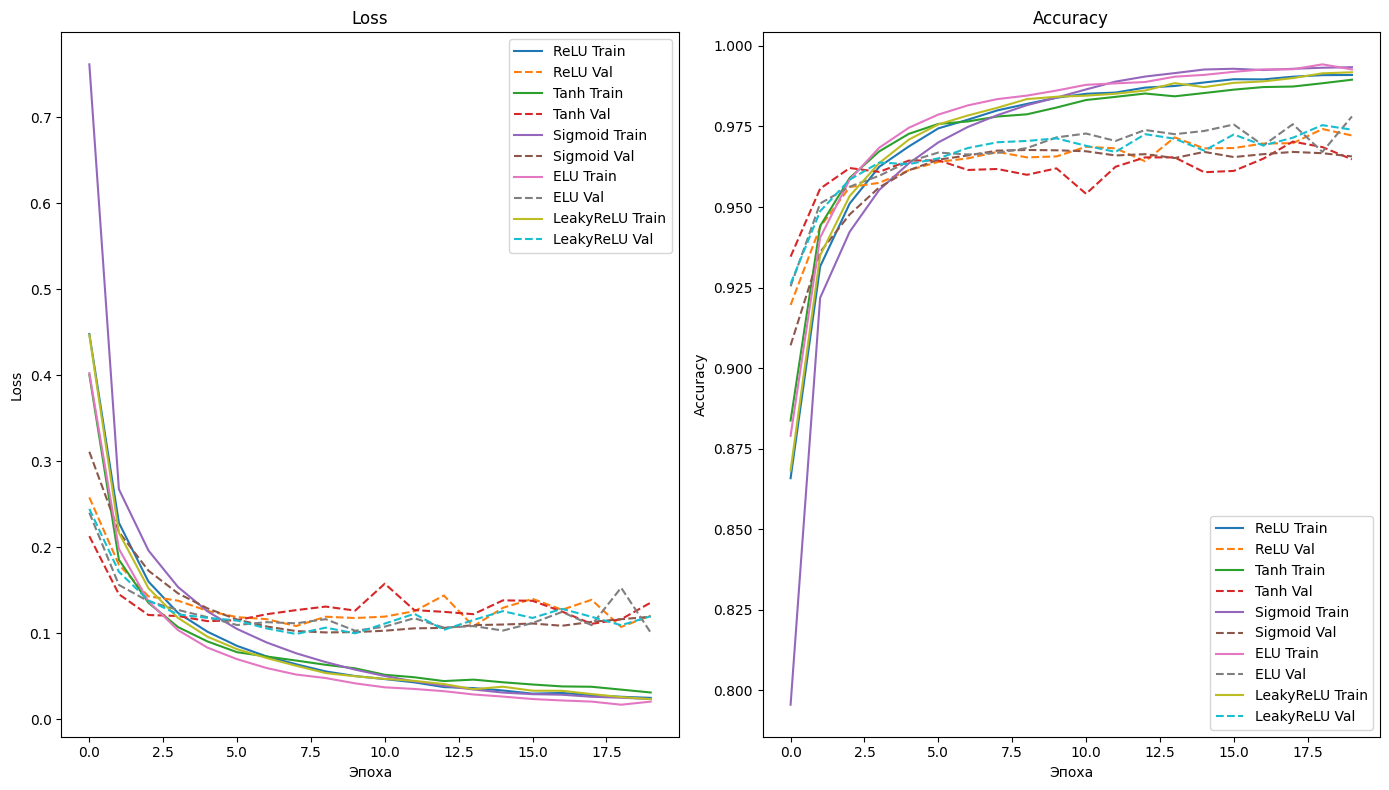

In [ ]:
plt.figure(figsize=(14, 8))

for name, (train_hist, val_hist) in history.items():
    train_loss, train_acc = zip(*train_hist)
    val_loss, val_acc = zip(*val_hist)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label=f'{name} Train')
    plt.plot(val_loss, label=f'{name} Val', linestyle='--')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label=f'{name} Train')
    plt.plot(val_acc, label=f'{name} Val', linestyle='--')

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Теперь вам предстоит написать свою первую сверточную нейросеть. Превая версия архитектура LeNet была предложена еще аж в 1998 году. Вам предлагается реализовать её в таком виде:


*   Свертки 3x3 переход из 1 карты в 6 + ReLU
*   MaxPooling 2x2
*   Свертки 3x3 переход из 6 карт в 16 + ReLU
*   MaxPooling 2x2
*   Выпрямление (flatten)
*   Полносвязный слой, 120 нейронов + ReLU
*   Полносвязный слой, 84 нейрона + ReLU
*   Классификационный слой, 10 нейронов

Свертки можно брать из nn.Conv2d, пулинг - из nn.MaxPool2d, их сигнатуры можно загуглить.





In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device)



In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20
train_history, val_history = learning_loop(
    train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=epochs
)

train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)

  5%|▌         | 1/20 [00:18<05:57, 18.82s/it]

epoch: 1; losses: 0.452097505603234, 0.11844471243917942; accuracy: 0.8578333333333333, 0.9628


 10%|█         | 2/20 [00:36<05:23, 17.96s/it]

epoch: 2; losses: 0.11100661579668522, 0.07931020125374198; accuracy: 0.96505, 0.9733


 15%|█▌        | 3/20 [00:53<05:04, 17.89s/it]

epoch: 3; losses: 0.07751551711584131, 0.06581814163699747; accuracy: 0.9757, 0.9773


 20%|██        | 4/20 [01:13<04:57, 18.61s/it]

epoch: 4; losses: 0.05950526278292139, 0.0526363309990149; accuracy: 0.9815833333333334, 0.9817


 25%|██▌       | 5/20 [01:36<05:04, 20.27s/it]

epoch: 5; losses: 0.04865490564778447, 0.04333840180980041; accuracy: 0.9846, 0.9859


 30%|███       | 6/20 [01:54<04:32, 19.48s/it]

epoch: 6; losses: 0.040313084528781476, 0.0399587828055839; accuracy: 0.98755, 0.9861


 35%|███▌      | 7/20 [02:14<04:14, 19.54s/it]

epoch: 7; losses: 0.03417093374996136, 0.03929574328009039; accuracy: 0.9896166666666667, 0.9873


 40%|████      | 8/20 [02:31<03:45, 18.81s/it]

epoch: 8; losses: 0.029405397556287547, 0.040311739587271585; accuracy: 0.9912833333333333, 0.9881


 45%|████▌     | 9/20 [02:49<03:24, 18.60s/it]

epoch: 9; losses: 0.02507056346203511, 0.04270847422594961; accuracy: 0.9926666666666667, 0.9875


 50%|█████     | 10/20 [03:08<03:04, 18.49s/it]

epoch: 10; losses: 0.021155119957495482, 0.048447213898788324; accuracy: 0.994, 0.9861


 55%|█████▌    | 11/20 [03:25<02:44, 18.27s/it]

epoch: 11; losses: 0.01842402243198206, 0.05259223028749693; accuracy: 0.9946833333333334, 0.9853


 60%|██████    | 12/20 [03:44<02:27, 18.49s/it]

epoch: 12; losses: 0.01577886192422981, 0.056867051081627144; accuracy: 0.9951166666666666, 0.9842


 65%|██████▌   | 13/20 [04:02<02:06, 18.12s/it]

epoch: 13; losses: 0.013688986378644283, 0.06402145822655293; accuracy: 0.99595, 0.9835


 70%|███████   | 14/20 [04:19<01:47, 17.91s/it]

epoch: 14; losses: 0.011711570929279939, 0.06044195453042812; accuracy: 0.9964, 0.9848


 75%|███████▌  | 15/20 [04:38<01:30, 18.12s/it]

epoch: 15; losses: 0.012481661598469751, 0.049435732786201336; accuracy: 0.9958, 0.9868


 80%|████████  | 16/20 [04:55<01:11, 17.91s/it]

epoch: 16; losses: 0.010758754329311584, 0.051456447019660116; accuracy: 0.99655, 0.9858


 85%|████████▌ | 17/20 [05:13<00:53, 17.80s/it]

epoch: 17; losses: 0.008907522561967684, 0.06138365809012248; accuracy: 0.9971833333333333, 0.9854


 90%|█████████ | 18/20 [05:31<00:35, 17.94s/it]

epoch: 18; losses: 0.007238658837732995, 0.06729185097434019; accuracy: 0.9976666666666667, 0.9852


 95%|█████████▌| 19/20 [05:48<00:17, 17.81s/it]

epoch: 19; losses: 0.007478474038131147, 0.06451064537269795; accuracy: 0.9974666666666666, 0.9859


100%|██████████| 20/20 [06:06<00:00, 18.33s/it]

epoch: 20; losses: 0.006694707813558246, 0.07963571447890068; accuracy: 0.9976666666666667, 0.9838


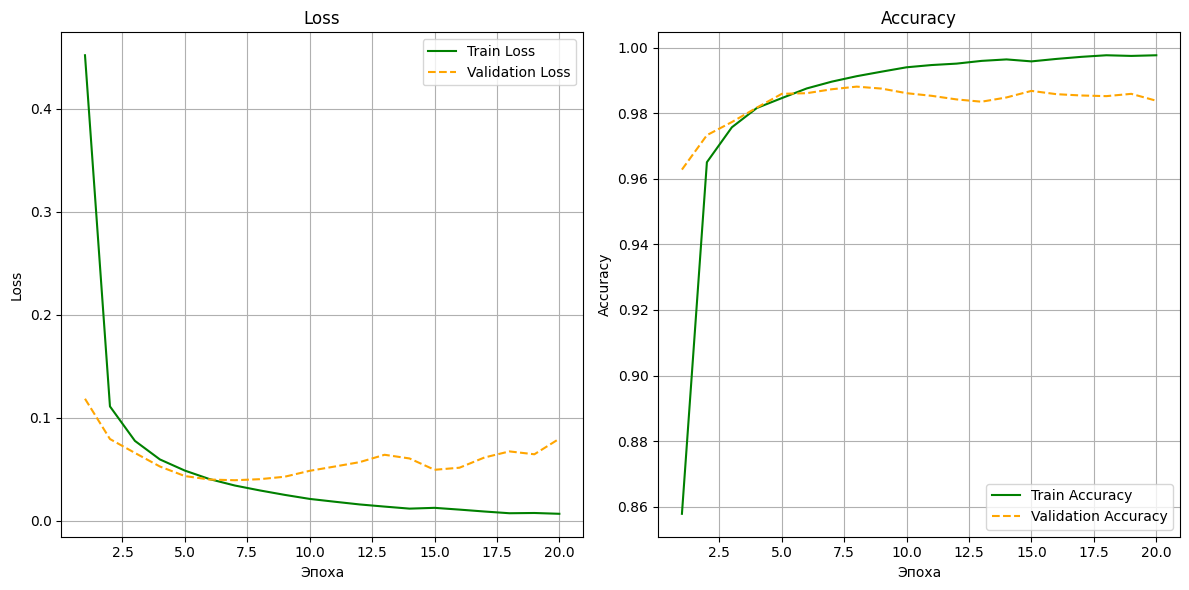

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="green")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="orange", linestyle='--')
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="green")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="orange", linestyle='--')
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Проанализируйте полученные результаты, постройте сравнительные графики для точности на валидационной выборке у трех разных моделей. В качестве задачи со звездочкой, можете попробовать поиграть со своей архитектурой сверточной нейронной сети (можно варьировать количество слоев, количество нейронов в них, добавлять в свертки padding, а в полносвязную часть skip-connections).